In [93]:
# import the appropriate libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from scipy import stats
from collections import Counter
import re
from datetime import datetime
import json
from SPARQLWrapper import SPARQLWrapper, JSON
import requests
from io import BytesIO
import ast
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
from collections import defaultdict
import cv2

#image analysis: first install dlib in your ada environment (1: conda activate ada , 2: install dlib)
import dlib 
#face recognition library, first install it in your ada environment (1: conda activate ada, 2: install face_recognition)
import face_recognition
from PIL import Image, ImageDraw

>In this part we want to extract actors' facial encodings, in order to use them as features for supervised and unsupervised learning. We are using the *actor_images.csv* file that we've created. It contains actor names, their correspoding pictures stored as a url with it's width and height. The code for that file can be found in the *people_images.ipynb* notebook. 

In [94]:
#Loads "actor_images.csv" file
actor_images = pd.read_csv('data/our_datasets/actor_images.csv')
actor_images.head()

,Actor,Image URL,Image height,Image width
0,Dustin Hoffman,https://image.tmdb.org/t/p/original/yFjTzJHE6A...,900,600
1,Edward Norton,https://image.tmdb.org/t/p/original/5XBzD5WuTy...,771,514
2,David Krumholtz,https://image.tmdb.org/t/p/original/6M2kk44Z1D...,1680,1120
3,Matthew Broderick,https://image.tmdb.org/t/p/original/papqFgpyro...,900,600
4,Ronny Cox,https://image.tmdb.org/t/p/original/cKkVkqft2R...,2000,1334


In [95]:
#Finding missing values => no URLs 
missing = actor_images == '-'
missing_images = actor_images[missing.any(axis=1)]
print(missing_images)

             Actor Image URL Image height Image width
69   Trevor Thomas         -          Nan         Nan
215  Peter Hinwood         -          Nan         Nan
324      Shih Kien         -          Nan         Nan


>Only 0.85% of the data is missing. We will disregard it for now as it is marginal

In [96]:
#actor_images without the missing urls
actor_cleaned = actor_images[~missing.any(axis=1)]

The following function *landmarks* is used to extract the facial landmarks and the facial encodings from an image, by using the face_recognition and OpenCV librairies.

Face landmarks are a set of 68 coordinates (x and y), corresponding to the implacement of human face specific landmarks such as eyes, nose, eyebrows, lips and chin in the image.

Face encodings are a set of 128 encodings, specific to a person. As explained in *Ng et al.,2019* : 
> *"In  the  face  encoding  and  feature  extraction  step,  deep  learning is  implemented  in  this  step  to determine which part of the  face is  important to be measured for the face recognition process. The  deep convolutions  neural  network  is  being  trained  by  loading  a  training  face  image  of  a  known  person,  load another picture of the  same known person, and  load a picture of a  totally different person,  then the neural network tweak accordingly based  to the result. After  lots of repeating training, the neural network learns to reliably generate 128 measurements for each person."* <br>
Reference: Ng, Ri & Lim, Kian & Lee, Chin-Poo & Abdul Razak, Siti Fatimah. (2019). Surveillance system with motion and face detection using histograms of oriented gradients. Indonesian Journal of Electrical Engineering and Computer Science. 14. 869-876. 10.11591/ijeecs.v14.i2.pp869-876. 

In this project we implemented one of the trained network from Open Face, *face_encodings*, to get the 128 measurements for our images*


In [97]:
'''
def landmarks(row):


    actor_name = row['Actor']
    image_url = row['Image URL']

    try:
        # Retrieve image URL
        img = requests.get(image_url)
        image_content = BytesIO(img.content)

        # Transform the image into an array
        img_array = np.asarray(Image.open(image_content))

        # Check if the image is black and white (grayscale)
        if len(img_array.shape) == 2:  # Grayscale image
            # Convert black and white image to RGB
            img_array_rgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
        elif len(img_array.shape) == 3 and img_array.shape[2] == 3:  # RGB image
            img_array_rgb = img_array
        else:
            raise ValueError("Unsupported image format")

        # Extract facial landmarks
        face_landmarks_list = face_recognition.face_landmarks(img_array_rgb)
        
        if face_landmarks_list:
            # Extract facial encodings
            face_encodings_list = face_recognition.face_encodings(img_array_rgb)
                                                                  
        else:
            face_encodings_list = np.nan

    except Exception as e:
        face_landmarks_list = np.nan
        face_encodings_list = np.nan
        
    return pd.Series({'Actor': actor_name, 'Landmarks': face_landmarks_list, 'Encodings':face_encodings_list})


    
face_encodings2 = actor_cleaned.apply(lambda row: landmarks(row), axis=1)
face_encodings2.to_csv('actor_features.csv')
'''

'\ndef landmarks(row):\n\n\n    actor_name = row[\'Actor\']\n    image_url = row[\'Image URL\']\n\n    try:\n        # Retrieve image URL\n        img = requests.get(image_url)\n        image_content = BytesIO(img.content)\n\n        # Transform the image into an array\n        img_array = np.asarray(Image.open(image_content))\n\n        # Check if the image is black and white (grayscale)\n        if len(img_array.shape) == 2:  # Grayscale image\n            # Convert black and white image to RGB\n            img_array_rgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)\n        elif len(img_array.shape) == 3 and img_array.shape[2] == 3:  # RGB image\n            img_array_rgb = img_array\n        else:\n            raise ValueError("Unsupported image format")\n\n        # Extract facial landmarks\n        face_landmarks_list = face_recognition.face_landmarks(img_array_rgb)\n        \n        if face_landmarks_list:\n            # Extract facial encodings\n            face_encodings_list

A the *landmarks* function takes a lot of time to run, we have extracted the returned dataframe to a .csv file, *actor_features.csv*

In [98]:
face_encodings = pd.read_csv("actor_features.csv")

In [99]:
face_encodings

,Unnamed: 0,Actor,Landmarks,Encodings
0,0,Dustin Hoffman,"[{'chin': [(141, 392), (141, 434), (141, 477),...","[array([ 0.0167025 , 0.12338186, -0.03214089,..."
1,1,Edward Norton,"[{'chin': [(123, 323), (131, 358), (141, 391),...","[array([-0.00984838, 0.17413326, 0.10402523,..."
2,2,David Krumholtz,"[{'chin': [(226, 713), (238, 803), (253, 892),...","[array([-0.18904248, 0.11554453, 0.05453956,..."
3,3,Matthew Broderick,"[{'chin': [(132, 373), (138, 413), (144, 453),...","[array([-1.50219575e-01, 1.07419252e-01, 9.2..."
4,4,Ronny Cox,"[{'chin': [(270, 723), (249, 839), (236, 953),...","[array([-0.08915272, 0.10389782, 0.07653827,..."
...,...,...,...,...
342,345,John Hurt,"[{'chin': [(124, 314), (134, 370), (145, 424),...","[array([-3.67913246e-02, 6.23679087e-02, 8.8..."
343,346,Schuyler Fisk,"[{'chin': [(135, 228), (134, 256), (136, 284),...","[array([-0.05912025, 0.19028406, 0.09844199,..."
344,347,Laura San Giacomo,"[{'chin': [(223, 632), (227, 705), (235, 777),...","[array([-0.04075871, 0.1082466 , 0.02687001,..."
345,348,Colin Firth,"[{'chin': [(374, 1248), (391, 1382), (416, 150...","[array([-1.13490149e-01, 4.34614718e-02, 3.6..."


In [100]:
# Filter the dataframe for missing values
face_encodings_cleaned = face_encodings.dropna()
missing =(len(face_encodings)-len(face_encodings_cleaned))/len(face_encodings)
print('Number of missing encodings is {:%}'.format(missing))


Number of missing encodings is 0.864553%


In [101]:
#We did not manage to obtain the encodings for these people.
rows_with_nan = face_encodings[face_encodings.isna().any(axis=1)]
rows_with_nan

,Unnamed: 0,Actor,Landmarks,Encodings
124,125,Tom Waits,[],NaN
165,166,Deborah Foreman,[],NaN
194,195,Lionel Barrymore,[],NaN


In [102]:
#Reset the row index as rows with missing values where removed
face_encodings_cleaned.reset_index(drop=True, inplace=True)

In [103]:
def parse_array_string(input_string):
    input_string = input_string.replace("array", "").replace("[[", "[").replace("]]", "]")

    array_content = re.search(r'\[([^[\]]*)\]', input_string).group(1)

    array_elements = array_content.split(',')

    array_values = [float(element) for element in array_elements]
    result_array = np.array(array_values)

    return result_array
def eval_landmarks(row):
    return eval(row)

def parse_encodings(row):
    return parse_array_string(row)

In [104]:
face_encodings_cleaned.loc[:,'Landmarks'] = face_encodings_cleaned['Landmarks'].apply(lambda x: eval_landmarks(x))
face_encodings_cleaned.loc[:,'Encodings'] = face_encodings_cleaned['Encodings'].apply(lambda x: parse_encodings(x))

In [105]:
#Check whether each row of the Encodings column contains only one array of encodings. Each row should have exactly 128 encodings. Remove the additional encodings if more than 128:
l_encodings = 128
length = len(face_encodings_cleaned)
for i in range(0,length):
    if len(face_encodings_cleaned['Encodings'].iloc[i]) > l_encodings:
        row = face_encodings_cleaned['Encodings'].iloc[i]
        length = len(row)
        print('Row number {} has {} encoding vectors'.format(i,length))
        #remove the additional encodings
        face_encodings_cleaned.loc[:,'Encodings'].iloc[i] = row[:128]

>Having extracted the facial encodings and landmakrs for each actor, we want to retrieve other features that we could use for classification or clustering. For the sake of comparison between actors, we will use proportions of certain landmarks with respect to two reference measures: one for face width (distance betweem the temples) and one for the face length (distance between the top of the nose bridge and the lowest point of the chin). For exemple, we will not look at the length of a nose, but as its size in proportion to the reference length. <br> 

In [106]:
# This function calculates the proportions described above by using the face landmarks
def face_proportions(row):

    facial_prop = pd.Series({
        'Actor': row['Actor'],
        'Eye Distance': np.nan,
        'Eye Position': np.nan,
        'Nose Length': np.nan,
        'Nose Width': np.nan,
        'Eyebrow Length': np.nan,
        'Face Shape': np.nan,
        'Cheek Bones': np.nan})
 
    try:
        landmarks = row['Landmarks'][0] 
    except (json.JSONDecodeError, IndexError):
        # Handle cases where 'Encodings' is not a valid JSON or the list is empty
        return facial_prop

    chin_landmarks = landmarks['chin']
    nose_landmarks = landmarks['nose_bridge']
    nose_width_landmarks = landmarks['nose_tip']
    left_eyebrow_landmarks = landmarks['left_eyebrow']
    right_eyebrow_landmakrs = landmarks['right_eyebrow']
    left_eye_landmarks = landmarks['left_eye']
    right_eye_landmarks = landmarks['right_eye']
    top_lip_landmarks = landmarks['top_lip']

    if not chin_landmarks or not nose_landmarks:
        return facial_prop

    #Get the maximum distance for x and y => we will standardize the distances by dividing them by the max values 
    x1 = chin_landmarks[0][0]
    x2 = chin_landmarks[-1][0]
    y1 = nose_landmarks[0][1]
    y2 = chin_landmarks[8][1]

    x_max = np.abs(x2 - x1)
    y_max = np.abs(y2 - y1)

    #Get Eye Distance
    #Eye Position: distance between the eyes and the edge of the chin (in y distance)
    if not left_eye_landmarks or not right_eye_landmarks:
        eye_dist = np.nan
        eye_position = np.nan
    else: 
        x_r = right_eye_landmarks[0][0]
        x_l = left_eye_landmarks[3][0]
        eye_dist = abs(x_r - x_l) / x_max

        y_r = right_eye_landmarks[0][1]
        y_l = left_eye_landmarks[3][1]
        chin_r = chin_landmarks[7][1]
        chin_l = chin_landmarks[9][1]

        eye_position = (abs(y_r - chin_r)/y_max + abs(y_l - chin_l)/y_max)/2


    facial_prop['Eye Distance'] = eye_dist
    facial_prop['Eye Position'] = eye_position 



    # Get nose withd and nose length
    if not nose_landmarks or not nose_width_landmarks:
        nose_length  = np.nan
        nose_width  = np.nan
    else:
        y_nose1 = nose_landmarks[0][1]
        y_nose2 = nose_width_landmarks[-1][1]
        x_nose1 = nose_width_landmarks[0][0]
        x_nose2 = nose_width_landmarks[-1][0]

        nose_length = abs(y_nose2 - y_nose1) / y_max
        nose_width = abs(x_nose2 - x_nose1) / x_max

    facial_prop['Nose Length'] = nose_length
    facial_prop['Nose Width'] = nose_width


    #Eye brow length: do for both eye brows and take the mean
    if not left_eyebrow_landmarks or not right_eyebrow_landmakrs:
        eyebrow_length = np.nan
    else: 
        x1_eyebrowl = left_eyebrow_landmarks[0][0]
        x2_eyebrowl = left_eyebrow_landmarks[-1][0]
        x1_eyebrowr = right_eyebrow_landmakrs[0][0]
        x2_eyebrowr = right_eyebrow_landmakrs[-1][0]
        eyebrow_length = (abs(x2_eyebrowl - x1_eyebrowl)/x_max + abs(x2_eyebrowr - x1_eyebrowr)/x_max)/2

    facial_prop['Eyebrow Length'] = eyebrow_length

    #Face shape: for the face shape, we will do face width on face length ratio . if close to 1 the face is square, if close to zero the face is long and narrow and if bigger than 1 the face is short and broad.
    face_shape = x_max / y_max
    facial_prop['Face Shape'] = face_shape

    # Cheek bones: x distance from chin[0] to chin[5]
    chin5 = chin_landmarks[5][0]
    chin11 = chin_landmarks[11][0]
    cheek_bones = (abs(chin5 - x1)/x_max + abs(chin11 - x2)/x_max)/2

    facial_prop['Cheek Bones'] = cheek_bones

    return facial_prop

In [107]:
facial_proportions =face_encodings_cleaned.apply(face_proportions, axis=1)

>**Features visualisation** Now that we have obtained the features (proportions of different disctinctives facial features, such as nose length, distance between eyes, etc..)

In [108]:
'''
feature_columns = facial_proportions.drop('Actor', axis =1)
feature_columns = feature_columns.dropna()

def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()
# Create the pairplot
g = sns.PairGrid(feature_columns)
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)
g.map_upper(reg_coef)

plt.suptitle('Feature visualisation', y=1.02, size=16)

plt.show()

'''


"\nfeature_columns = facial_proportions.drop('Actor', axis =1)\nfeature_columns = feature_columns.dropna()\n\ndef reg_coef(x,y,label=None,color=None,**kwargs):\n    ax = plt.gca()\n    r,p = pearsonr(x,y)\n    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')\n    ax.set_axis_off()\n# Create the pairplot\ng = sns.PairGrid(feature_columns)\ng.map_diag(sns.distplot)\ng.map_lower(sns.regplot)\ng.map_upper(reg_coef)\n\nplt.suptitle('Feature visualisation', y=1.02, size=16)\n\nplt.show()\n\n"

> We observe that the nose length is normally distributed, whereas the eye distance and nose width are skewed to the right and left, respectively.Eye distance and Nose length are not correlated, Nose width and Eye distance are weakly positively correlated, and Nose width and Nose length are weakly negatively correlated. This means that we can consider those three parameters as independant of each other and use them for our analysis as such.

In [109]:
'''
#Creates a boxplot for each face proportion
plt.figure(figsize=(10, 6))
sns.boxplot(data=feature_columns, palette='Set2')
plt.title('Box Plots for Facial Proportions')
plt.ylabel('Facial Proportions {%}')
plt.legend()
plt.show()
'''

"\n#Creates a boxplot for each face proportion\nplt.figure(figsize=(10, 6))\nsns.boxplot(data=feature_columns, palette='Set2')\nplt.title('Box Plots for Facial Proportions')\nplt.ylabel('Facial Proportions {%}')\nplt.legend()\nplt.show()\n"

>The box plots allow us to visualise outliers . Discarding feature outliers can improve model accuracy

>For each graph, from top to bottom we have : upper outliers (dots), maximum value (first plain line), third quantile (first box line), median (middle box line), first quantile (last box line), minimum value (last plain line), lower outliers (dots)

### Let's have a look at the actors

Using the face encodings, the face_recognition library offers a function that calculates the euclidean distance between the faces. This measurement could be used for clustering algorithms. 

In [110]:
#Calculates the euclidean distance for each actor, with all the other actors.
def euclidean_dist(df,encoding):
    rows = df['Encodings'].to_list()
    return face_recognition.api.face_distance(rows,encoding)

In [111]:
face_encodings_cleaned['Dist'] = face_encodings_cleaned['Encodings'].apply(lambda x: euclidean_dist(face_encodings_cleaned,x))

C:\Users\mat1l\AppData\Local\Temp\ipykernel_17940\3866354628.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  face_encodings_cleaned['Dist'] = face_encodings_cleaned['Encodings'].apply(lambda x: euclidean_dist(face_encodings_cleaned,x))


In [112]:
#Add a column with actor ID, corresponding to the row number of that actor in the face_encodings_cleanded dataframe. 
face_encodings_cleaned['ActorID'] = face_encodings_cleaned.index

C:\Users\mat1l\AppData\Local\Temp\ipykernel_17940\3966570431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  face_encodings_cleaned['ActorID'] = face_encodings_cleaned.index


By using the ActorID, we can retrieve the euclidean distance between two actors from the following matrix. For instance, if we want to know the euclidean distance between actor n and actor m, we need to extract the (n,m) instance from the matrix. It is a symmetrical matrix 


In [113]:
matrix_values = face_encodings_cleaned['Dist'].values

# Convert the list of lists to a NumPy array
matrix_array = np.array([x for x in matrix_values])

matrix_upper = np.triu(matrix_array)

mask_matrix = np.tril(np.ones_like(matrix_array, dtype=bool))

HeatMap for distances between actors

<Axes: >

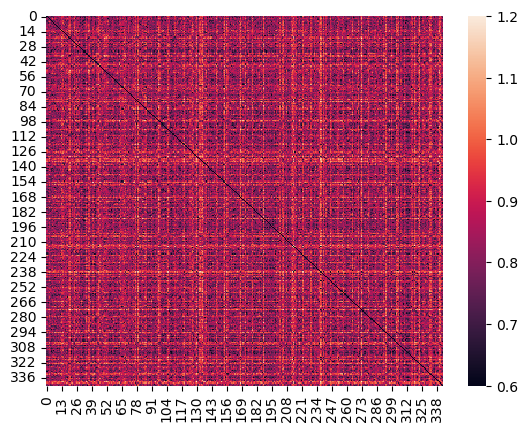

In [114]:
sns.heatmap(matrix_array, vmin=0.6, vmax=1.2)

c:\Users\mat1l\anaconda3\envs\ada\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\mat1l\anaconda3\envs\ada\lib\site-packages\seaborn\matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
c:\Users\mat1l\anaconda3\envs\ada\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\mat1l\anaconda3\envs\ada\lib\site-packages\seaborn\matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


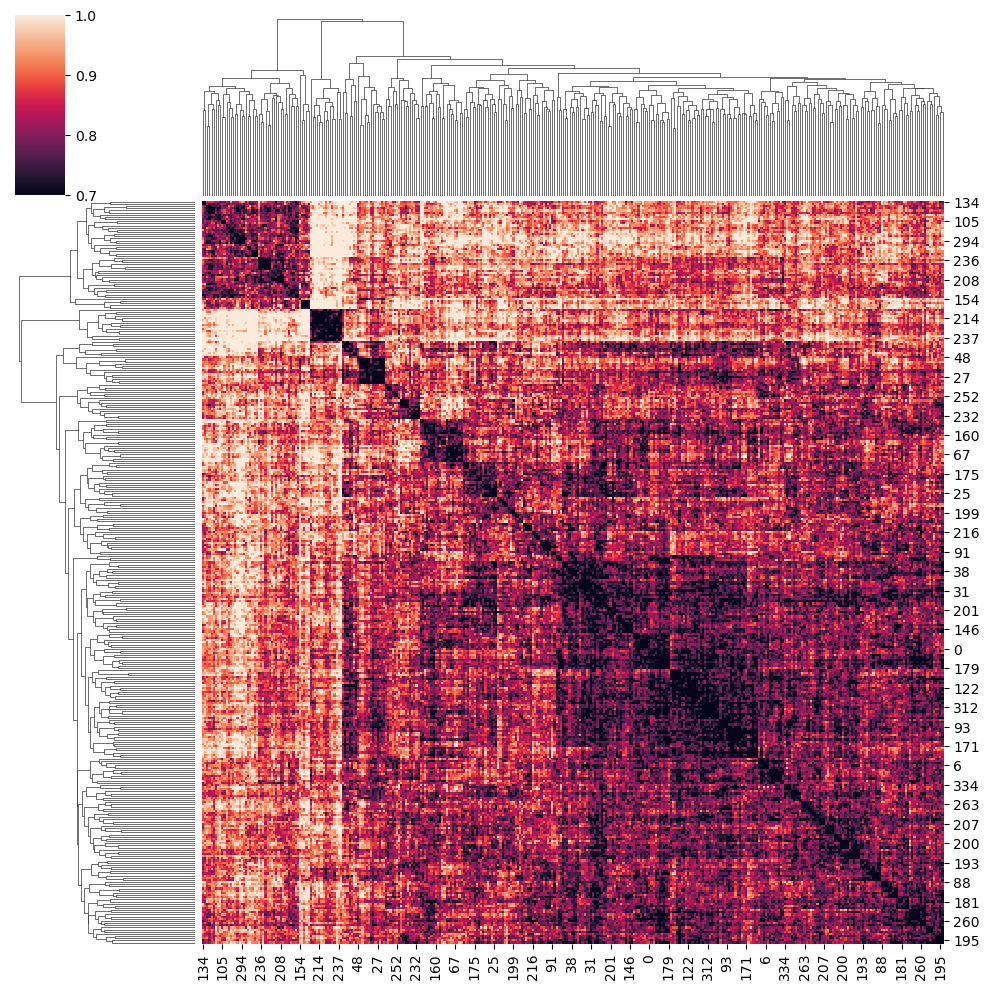

In [115]:
sns.clustermap(matrix_array, vmin=0.7, vmax=1)

Now that we have obtained the features from the actor images, let's combine them with the information we have from the CMU dataset

In [116]:
tropes = pd.read_csv('tropes_characters_ethnicity.csv')

In [117]:
# get the gender and ethnicity for each actor: 

face_encodings_cleaned= face_encodings_cleaned.rename(columns={'Actor': 'ActorName'})

actor_gender_ethn_height_age_df = tropes.drop_duplicates(subset='ActorName')[['ActorName','ActorGender','StrActorEthnicity','ActorHeight','ActorAge']]

actor_gender_ethn_height_age_df = face_encodings_cleaned.merge(actor_gender_ethn_height_age_df, on='ActorName', how='left')

In [118]:
#Creating a column for each encoding
encodings_expanded = pd.DataFrame(face_encodings_cleaned['Encodings'].tolist(), index=face_encodings_cleaned['Encodings'].index)
distance_expanded = pd.DataFrame(face_encodings_cleaned['Dist'].tolist(), index=face_encodings_cleaned['Dist'].index)

num_columns_encod = len(encodings_expanded.columns)
num_columns_eucldist = len(distance_expanded.columns)

column_names_encod = [f"encod_{i + 1}" for i in range(num_columns_encod)]
column_names_dist = [f"actorID={i}" for i in range(num_columns_eucldist)]

# Rename the new columns
encodings_expanded.columns = column_names_encod
distance_expanded.columns = column_names_dist

# Concatenate the new columns with the original Series
df_features = pd.concat([face_encodings_cleaned['ActorID'], 
                         face_encodings_cleaned['ActorName'], 
                         actor_gender_ethn_height_age_df['ActorGender'], 
                         actor_gender_ethn_height_age_df['StrActorEthnicity'], 
                         actor_gender_ethn_height_age_df['ActorHeight'], 
                         actor_gender_ethn_height_age_df['ActorAge'], 
                         encodings_expanded, 
                         distance_expanded,facial_proportions], 
                         axis=1).drop(columns=['Actor'])

In [119]:
columns_with_missing_data = df_features.columns[df_features.isna().any()].tolist()
print('The columns for which data is missing are {}'.format(columns_with_missing_data))

The columns for which data is missing are ['ActorGender', 'StrActorEthnicity', 'ActorHeight']


In [120]:
columns_with_missing_data

['ActorGender', 'StrActorEthnicity', 'ActorHeight']

In [121]:
missing_gender = df_features[df_features['ActorGender'].isna()]
print('Percentage of actors with missing data on gender: {:%} \nThe actor name and id are: {} {}'.format(len(missing_gender)/(len(df_features)), missing_gender['ActorName'], missing_gender['ActorID']))

Percentage of actors with missing data on gender: 0.290698% 
The actor name and id are: 270    Junjie Qin
Name: ActorName, dtype: object 270    270
Name: ActorID, dtype: int64


In [122]:
missing_height = df_features[df_features['ActorHeight'].isna()]
print('Percentage of actors with missing data on gender: {:%}'.format(len(missing_height)/len(df_features)))

Percentage of actors with missing data on gender: 7.848837%


In [123]:
missing_ethn = df_features[df_features['StrActorEthnicity'].isna()]
percentage_missing = len(missing_ethn)/len(df_features) 
print('Percentage of actors with missing data on gender: {:%}'.format(percentage_missing))

Percentage of actors with missing data on gender: 40.406977%


### Correlation between encodings

<Axes: >

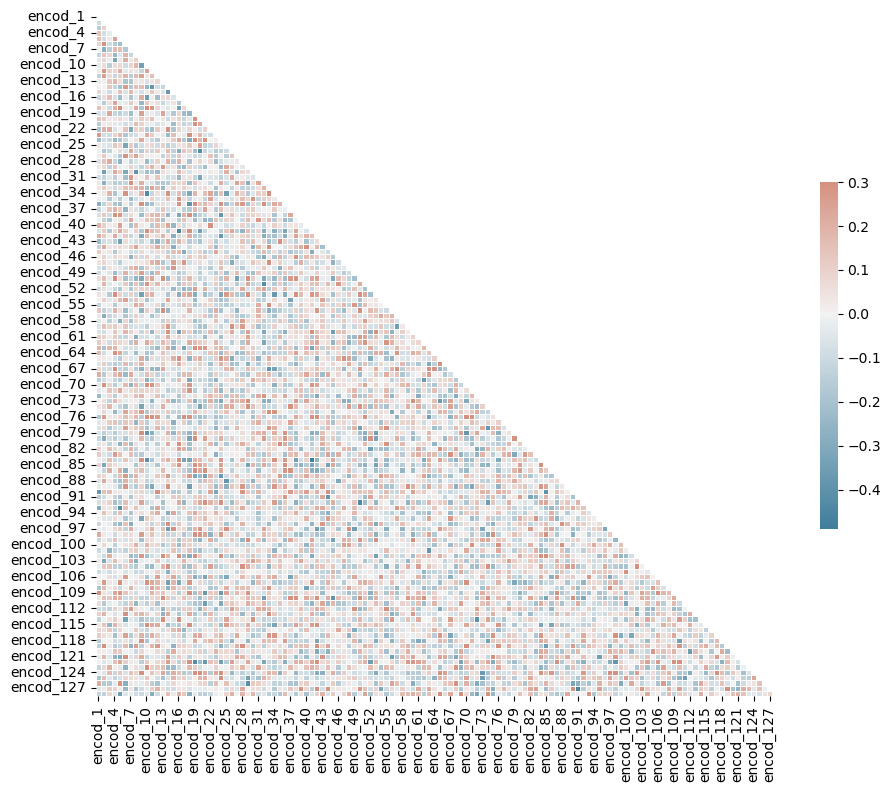

In [124]:

features = df_features.loc[:,'encod_1':'encod_128']

# Compute the correlation matrix
corr = features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [125]:
# Data for which ethnicity is not missing
df_with_ethnicity = df_features[df_features['StrActorEthnicity'].notna()]

#Data for which the Actor height is not missing = 
df_with_height = df_features[df_features['ActorHeight'].notna()]

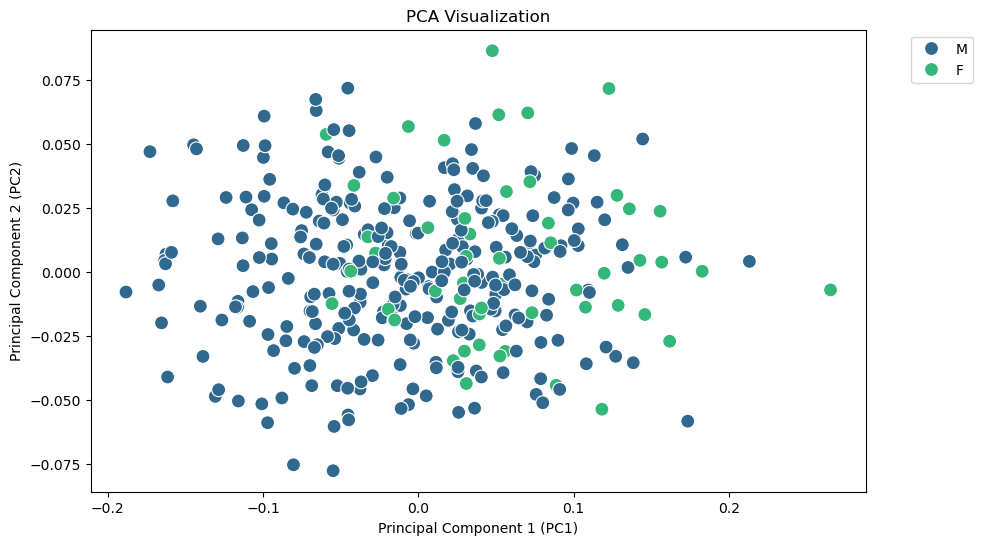

In [126]:
numeric_columns = df_features.loc[:, 'Eye Distance':'Cheek Bones']

# Perform PCA
num_components = 2  # Choose the number of components for 2D visualization
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(numeric_columns)

# Create a DataFrame with PCA results
df_pca = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(num_components)])

# Concatenate the principal components DataFrame with the original DataFrame
df_result = pd.concat([df_features[['ActorID','ActorGender','StrActorEthnicity','ActorHeight']], df_pca], axis=1)

# Visualize the PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca.columns[0], y=df_pca.columns[1], data=df_result, hue='ActorGender', palette='viridis', s=100)
plt.title('PCA Visualization')
plt.xlabel(f'Principal Component 1 ({df_pca.columns[0]})')
plt.ylabel(f'Principal Component 2 ({df_pca.columns[1]})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

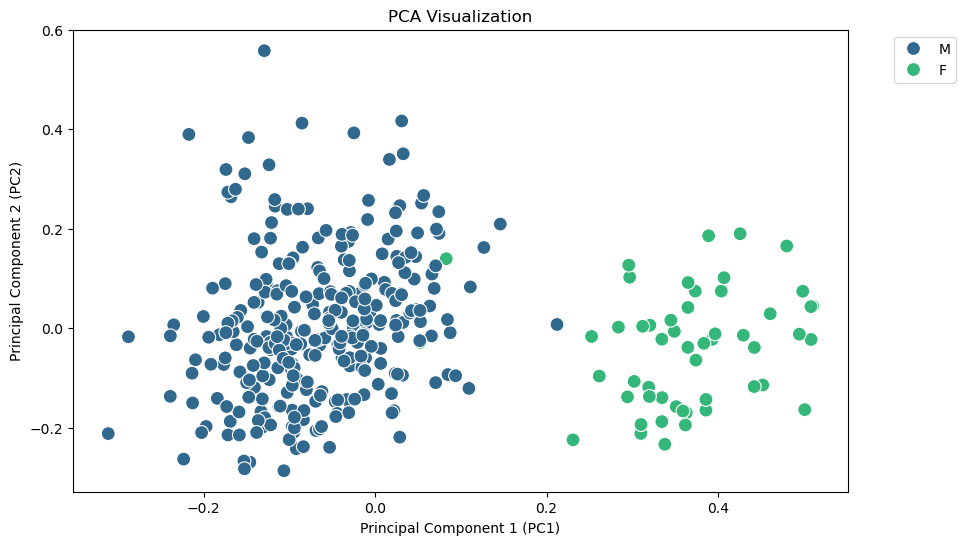

In [127]:
numeric_columns = df_features.loc[:, 'encod_1':'encod_128']

# Perform PCA
num_components = 2  # Choose the number of components for 2D visualization
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(numeric_columns)

# Create a DataFrame with PCA results
df_pca = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(num_components)])

# Concatenate the principal components DataFrame with the original DataFrame
df_result = pd.concat([df_features[['ActorID', 'ActorGender', 'ActorName']], df_pca], axis=1)

# Visualize the PCA results
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    x=df_pca.columns[0],
    y=df_pca.columns[1],
    data=df_result,
    hue='ActorGender',  # Color points based on the 'ActorGender' column
    palette='viridis',
    s=100)
plt.title('PCA Visualization')
plt.xlabel(f'Principal Component 1 ({df_pca.columns[0]})')
plt.ylabel(f'Principal Component 2 ({df_pca.columns[1]})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [128]:
'''
numeric_columns = df_features.loc[:, 'encod_1':'encod_128']

# Perform PCA
num_components = 2  # Choose the number of components for 2D visualization
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(numeric_columns)

# Create a DataFrame with PCA results
df_pca = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(num_components)])

# Concatenate the principal components DataFrame with the original DataFrame
df_result = pd.concat([df_features[['ActorID', 'ActorGender', 'ActorName']], df_pca], axis=1)

# Visualize the PCA results
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    x=df_pca.columns[0],
    y=df_pca.columns[1],
    data=df_result,
    hue='ActorGender',  # Color points based on the 'ActorGender' column
    palette='viridis',
    s=100
)

for line in range(0, df_result.shape[0]):
     if df_result['ActorGender'][line] == 'F':
        scatter_plot.text(df_result[df_pca.columns[0]][line],
                        df_result[df_pca.columns[1]][line],
                        df_result['ActorName'][line],
                        horizontalalignment='left',
                        size='medium',
                        color='black'
                        )
plt.title('PCA Visualization')
plt.xlabel(f'Principal Component 1 ({df_pca.columns[0]})')
plt.ylabel(f'Principal Component 2 ({df_pca.columns[1]})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
'''


"\nnumeric_columns = df_features.loc[:, 'encod_1':'encod_128']\n\n# Perform PCA\nnum_components = 2  # Choose the number of components for 2D visualization\npca = PCA(n_components=num_components)\npca_result = pca.fit_transform(numeric_columns)\n\n# Create a DataFrame with PCA results\ndf_pca = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(num_components)])\n\n# Concatenate the principal components DataFrame with the original DataFrame\ndf_result = pd.concat([df_features[['ActorID', 'ActorGender', 'ActorName']], df_pca], axis=1)\n\n# Visualize the PCA results\nplt.figure(figsize=(10, 6))\nscatter_plot = sns.scatterplot(\n    x=df_pca.columns[0],\n    y=df_pca.columns[1],\n    data=df_result,\n    hue='ActorGender',  # Color points based on the 'ActorGender' column\n    palette='viridis',\n    s=100\n)\n\nfor line in range(0, df_result.shape[0]):\n     if df_result['ActorGender'][line] == 'F':\n        scatter_plot.text(df_result[df_pca.columns[0]][line],\n           

### Let's have a look at the characters now

In [129]:
tropes_features = tropes.drop(columns=['Freebase_charactermap','ActorEthnicity Label','Freebase_actorID','Freebase_movieID','Wiki_movieID','Unnamed: 0'])

distance = df_features.loc[:,'actorID=0':'actorID=343']
merge_features = tropes_features.drop(columns=['ActorGender','ActorHeight','ActorAge','StrActorEthnicity']).merge(df_features.drop(columns=distance), on='ActorName',how='left')

In [130]:
missing_data = merge_features.columns[merge_features.isna().any()].tolist()
print(missing_data)

['ActorDOB', 'BoxOffice', 'ActorID', 'ActorGender', 'StrActorEthnicity', 'ActorHeight', 'ActorAge', 'encod_1', 'encod_2', 'encod_3', 'encod_4', 'encod_5', 'encod_6', 'encod_7', 'encod_8', 'encod_9', 'encod_10', 'encod_11', 'encod_12', 'encod_13', 'encod_14', 'encod_15', 'encod_16', 'encod_17', 'encod_18', 'encod_19', 'encod_20', 'encod_21', 'encod_22', 'encod_23', 'encod_24', 'encod_25', 'encod_26', 'encod_27', 'encod_28', 'encod_29', 'encod_30', 'encod_31', 'encod_32', 'encod_33', 'encod_34', 'encod_35', 'encod_36', 'encod_37', 'encod_38', 'encod_39', 'encod_40', 'encod_41', 'encod_42', 'encod_43', 'encod_44', 'encod_45', 'encod_46', 'encod_47', 'encod_48', 'encod_49', 'encod_50', 'encod_51', 'encod_52', 'encod_53', 'encod_54', 'encod_55', 'encod_56', 'encod_57', 'encod_58', 'encod_59', 'encod_60', 'encod_61', 'encod_62', 'encod_63', 'encod_64', 'encod_65', 'encod_66', 'encod_67', 'encod_68', 'encod_69', 'encod_70', 'encod_71', 'encod_72', 'encod_73', 'encod_74', 'encod_75', 'encod_76

In [131]:
merge_features_missing_encodings = merge_features[merge_features['encod_1'].isna()]
merge_features_missing_height = merge_features[merge_features['ActorHeight'].isna()]
print('The encodings are missing for {:%} of characters. \nThe height is missing for {:%} of characters'.format(len(merge_features_missing_encodings)/len(merge_features), len(merge_features_missing_height)/len(merge_features)))

The encodings are missing for 1.397206% of characters. 
The height is missing for 7.385230% of characters


In [132]:
#Create dfs without missing encodings and height
merge_features_filtered = merge_features[merge_features['encod_1'].notna()]
merge_features_filtered_height = merge_features_filtered[merge_features_filtered['ActorHeight'].notna()]

In [133]:
merge_features_filtered.reset_index(drop=True, inplace=True)

In [134]:
#Add the 'Dist' column, which contains an array of euclidean distance for the actor playing the character
merge_features_filtered = merge_features_filtered.merge(face_encodings_cleaned.drop(columns='ActorID'), on='ActorName', how='left').drop(columns=['Landmarks','Dist'])

#### Obtaining the euclidean distance between each character:

In [135]:
# for 494 characters, we obtain a vector of 494 euclidean distances
merge_features_filtered['Dist'] = merge_features_filtered['Encodings'].apply(lambda x: euclidean_dist(merge_features_filtered,x))

In [136]:
#Expand each distance into a column 
distances = pd.DataFrame(merge_features_filtered['Dist'].tolist(), index=merge_features_filtered['Dist'].index)
num_columns_eucldist = len(distances.columns)
column_names_dist = [f"character={i}" for i in range(num_columns_eucldist)]
distances.columns = column_names_dist
merge_features_filtered = pd.concat([merge_features_filtered,distances],axis=1)


In [137]:
#Set all distances equal to 0 (characters played by the same actor) to 0.6 (threshold)

merge_features_filtered[column_names_dist] = merge_features_filtered[column_names_dist].replace(0, 0.6)

### Hirearchical Clustering - euclidean distances between characters

In [138]:
palette = sns.color_palette("Set1", len(merge_features_filtered['Trope'].unique()))
color_mapping = dict(zip(merge_features_filtered['Trope'].unique(), palette))

# Use the dictionary to map colors to each row in the 'Trope' column
row_colors = merge_features_filtered['Trope'].map(color_mapping)

c:\Users\mat1l\anaconda3\envs\ada\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\mat1l\anaconda3\envs\ada\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


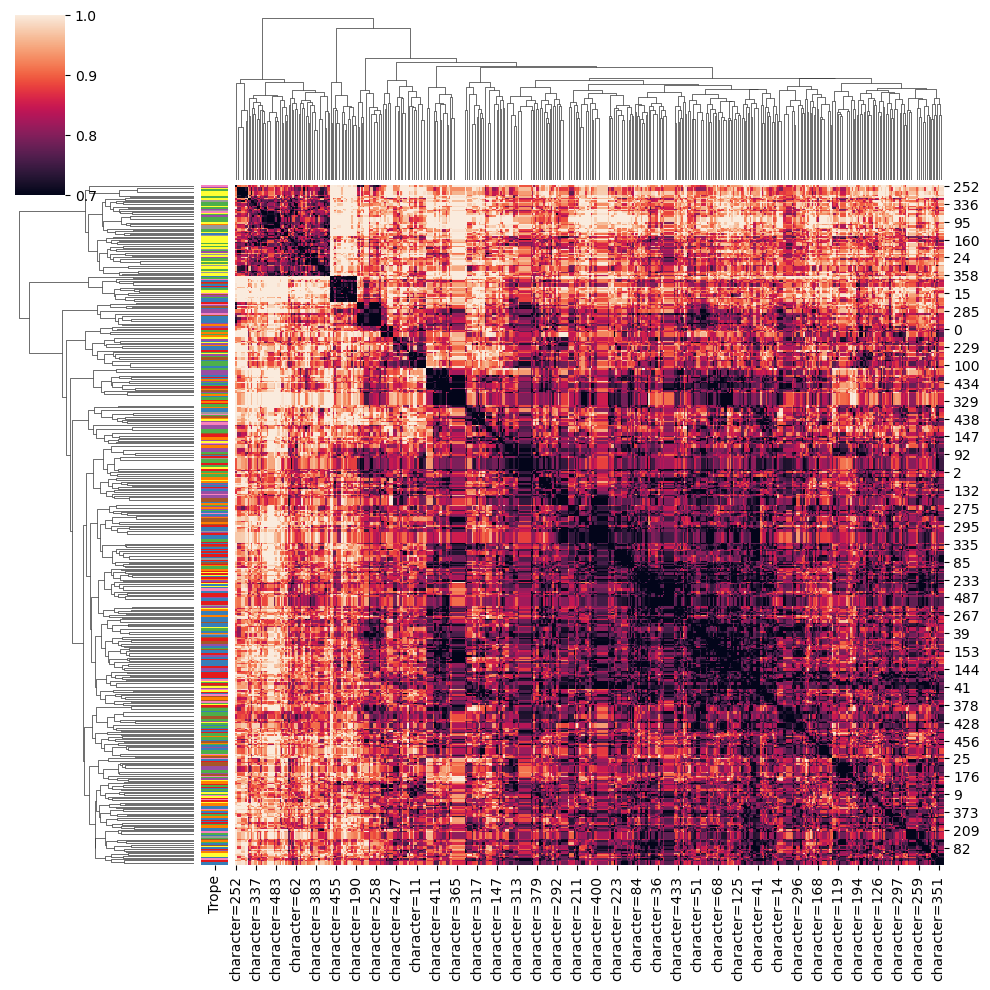

In [139]:
cluster_characters = sns.clustermap(merge_features_filtered.loc[:,'character=0':'character=493'], vmin=0.7, vmax=1, row_colors=row_colors)

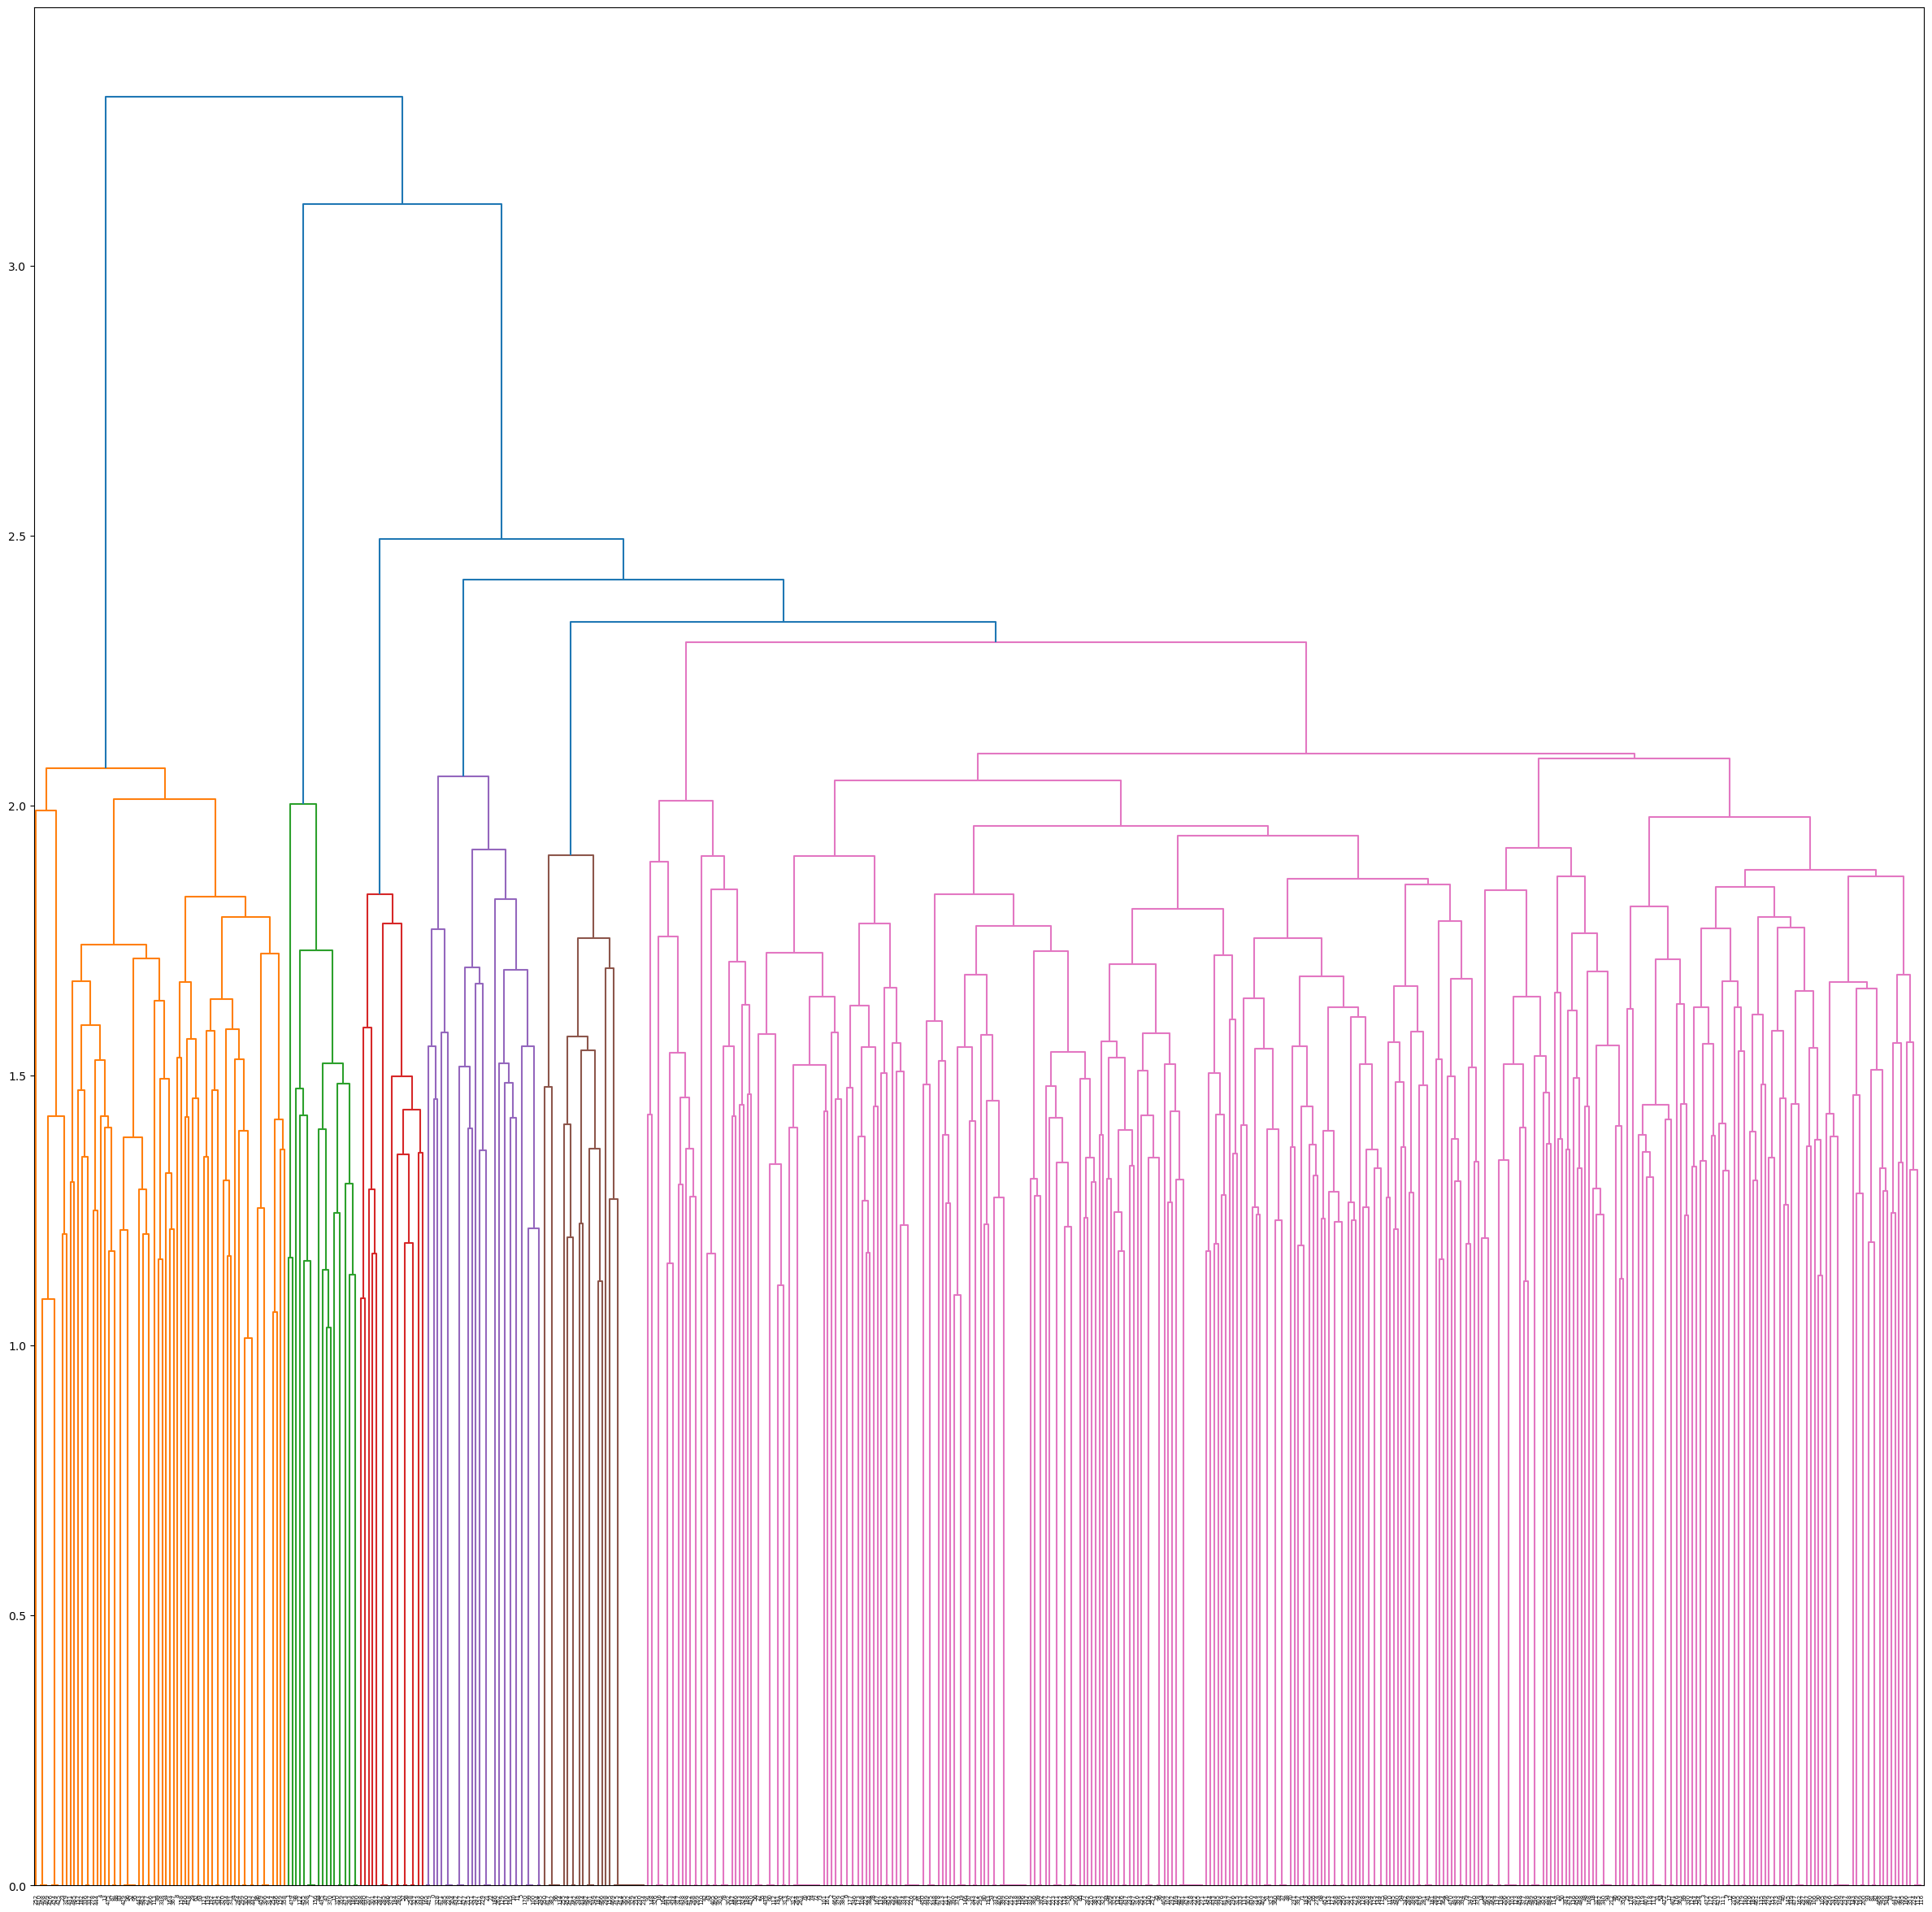

In [140]:
plt.figure(figsize=(30,30))
linkage_matrix = linkage(merge_features_filtered.loc[:,'character=0':'character=493'], method='average', metric='euclidean')

# Plot the hierarchical clustering dendrogram
dendrogram_char = dendrogram(linkage_matrix)

# Show the plot
plt.show()

In [141]:
dendrogram_char.keys()

dict_keys(['icoord', 'dcoord', 'ivl', 'leaves', 'color_list', 'leaves_color_list'])

In [142]:
cluster_df = pd.DataFrame(list(zip(dendrogram_char['leaves'], dendrogram_char['leaves_color_list'])),columns =['Character', 'Cluster_Color'])
cluster_df=cluster_df.set_index('Character')
#cluster_df['Character'].astype(int)
#cluster_df=cluster_df.sort_values(by='Character', ascending=True)

In [143]:
merge_features_filtered=merge_features_filtered.join(cluster_df['Cluster_Color'])

In [144]:
merge_features_filtered

,Trope,CharacterName,ActorName,ActorDOB,MovieName,Genres,Decade,ReleaseDate,BoxOffice,ActorID,...,character=485,character=486,character=487,character=488,character=489,character=490,character=491,character=492,character=493,Cluster_Color
0,evil_character,Aaron Hallam,Benicio del Toro,1967.0,The Hunted,"['Thriller', 'Crime Fiction', 'Action', 'Drama']",2000.0,2003.0,45496534.0,137.0,...,0.920088,0.955437,0.896109,0.818196,0.796451,0.913488,0.877132,0.865152,0.886374,C4
1,mean_officer,Abel Turner,Samuel L. Jackson,1948.0,Lakeview Terrace,"['Thriller', 'Crime Thriller', 'Drama', 'Psych...",2000.0,2008.0,44653637.0,273.0,...,1.030991,1.094637,0.899285,1.080602,1.011343,1.086823,0.935532,1.068964,1.015278,C2
2,charismatic_charmer,Abu,Sabu Dastagir,1924.0,The Thief of Bagdad,"['Adventure', 'Costume drama', 'Action/Adventu...",1940.0,1940.0,NaN,72.0,...,0.904739,0.868729,0.796828,0.827585,0.873609,0.825196,0.805414,0.962042,0.887089,C6
3,charismatic_charmer,Achilles,Brad Pitt,1963.0,Troy,"['Sword and Sandal', 'Adventure', 'Costume dra...",2000.0,2004.0,497409852.0,193.0,...,0.866867,0.855930,0.844569,0.795748,0.768826,0.809901,0.845171,0.836149,0.822245,C6
4,laidback_freebird,Agatha,Samantha Morton,1977.0,Minority Report,"['Crime Fiction', 'Thriller', 'Science Fiction...",2000.0,2002.0,358372926.0,178.0,...,0.765605,0.986672,0.850989,1.054280,0.833710,0.925872,0.898188,0.927672,0.922846,C1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,charismatic_charmer,Wolverine,Hugh Jackman,1968.0,X-Men,"['Thriller', 'Science Fiction', 'Superhero mov...",2000.0,2000.0,296339527.0,117.0,...,0.874003,0.892036,0.799089,0.804257,0.600000,0.716923,0.909731,0.776752,0.824359,C6
490,charismatic_charmer,Woody Deane,Kevin Zegers,1984.0,It's a Boy Girl Thing,"['Romantic comedy', 'Romance Film', 'Comedy', ...",2000.0,2006.0,7385434.0,290.0,...,0.939456,0.784583,0.797258,0.792315,0.716923,0.600000,0.875587,0.744924,0.813066,C6
491,old_wise_quirky,Yoda,Frank Oz,1944.0,Star Wars Episode V: The Empire Strikes Back,"['Science Fiction', 'Adventure', 'Space opera'...",1980.0,1980.0,538375067.0,311.0,...,0.922440,0.754430,0.821097,0.849637,0.909731,0.875587,0.600000,0.879763,0.592113,C6
492,skilled_badass,Zohan,Adam Sandler,1966.0,You Don't Mess with the Zohan,"['Action', 'Drama', 'Comedy']",2000.0,2008.0,201802891.0,57.0,...,0.928542,0.755154,0.835492,0.741621,0.776752,0.744924,0.879763,0.600000,0.760425,C6


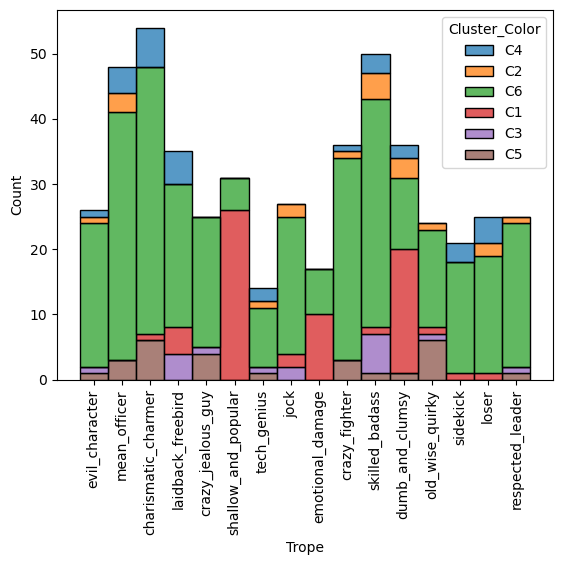

In [145]:
sns.histplot(data=merge_features_filtered, x='Trope', hue='Cluster_Color',multiple="stack")
plt.xticks(rotation=90)
plt.show()


In [146]:
subgroupC6=merge_features_filtered[merge_features_filtered['Cluster_Color']=='C6']
# Filter columns based on the list of numbers
columns_to_drop = [col for col in subgroupC6.loc[:,'character=0':'character=493'].columns if int(col.split('=')[-1]) not in subgroupC6.index]

# Create a new DataFrame with only the selected columns
subgroupC6 = subgroupC6.drop(columns=columns_to_drop)

c:\Users\mat1l\anaconda3\envs\ada\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\mat1l\anaconda3\envs\ada\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


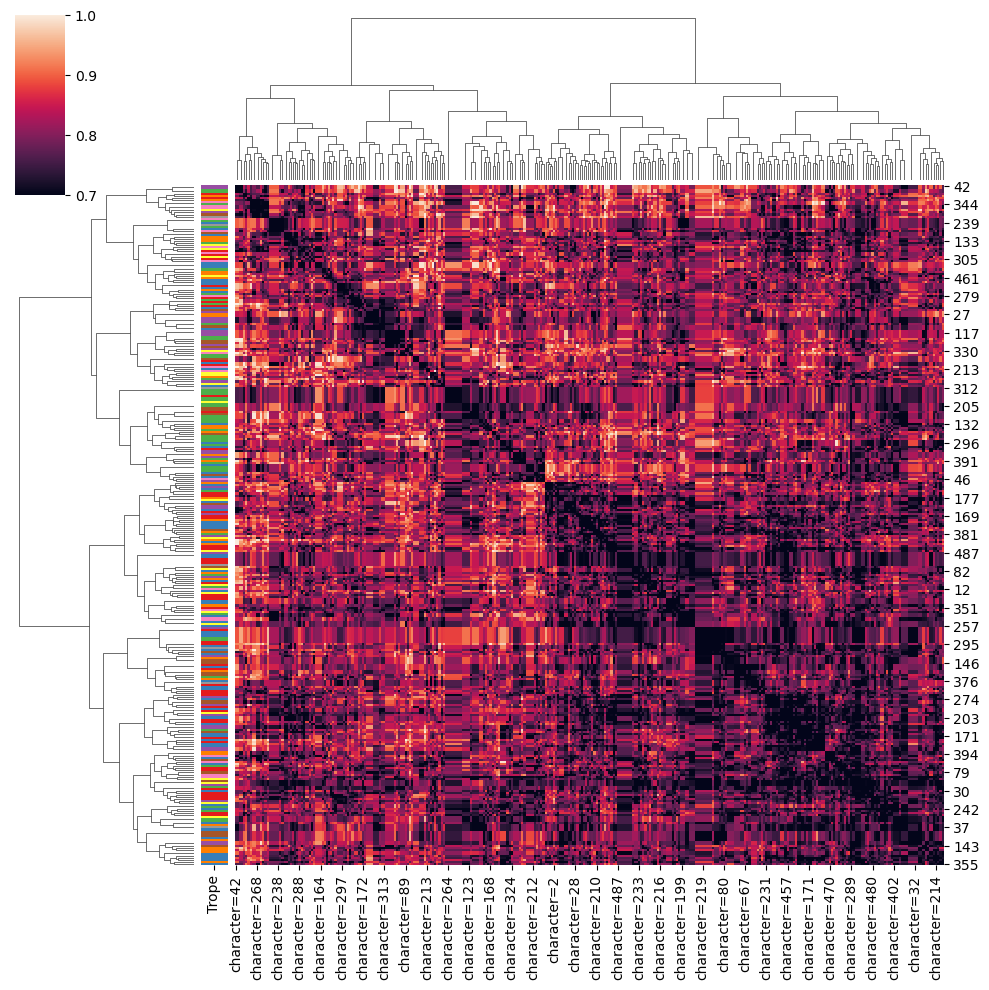

In [147]:
cluster_characters = sns.clustermap(subgroupC6.loc[:,'character=2':'character=493'], vmin=0.7, vmax=1, row_colors=row_colors, method='ward')

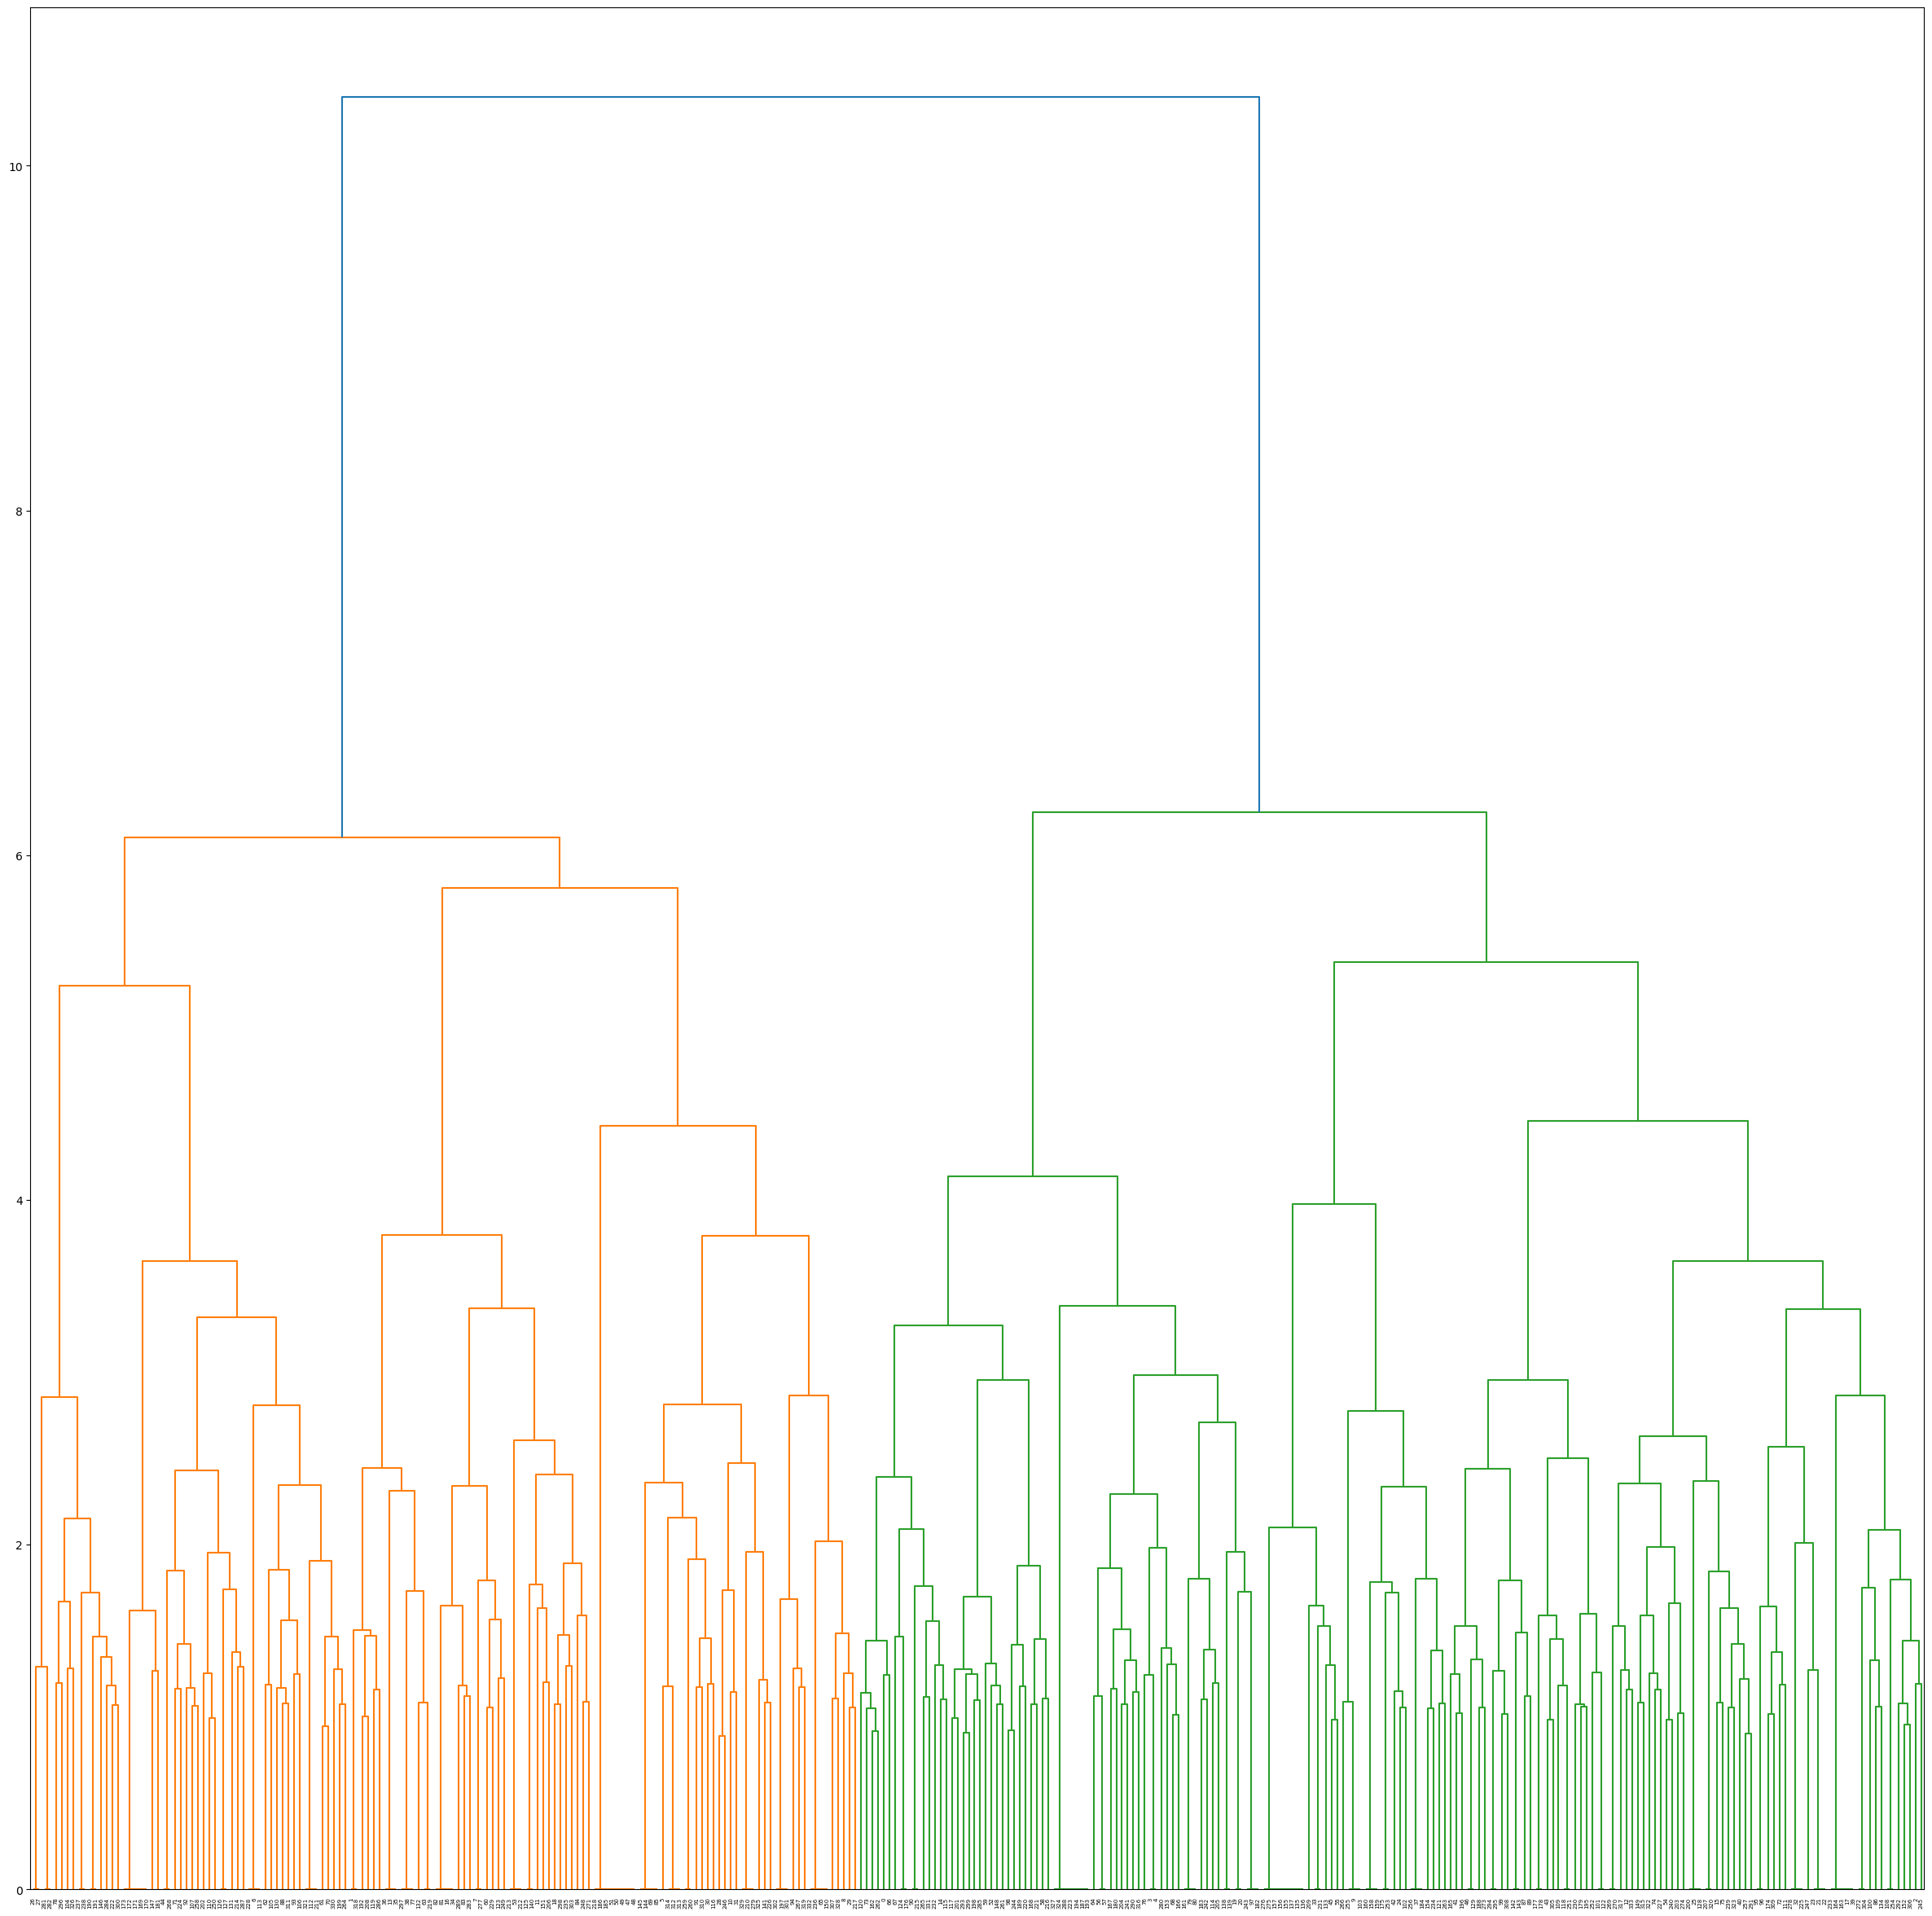

In [148]:
plt.figure(figsize=(30,30))
linkage_matrix_C6 = linkage(subgroupC6.loc[:,'character=2':'character=493'], method='ward', metric='euclidean')

# Plot the hierarchical clustering dendrogram
dendrogram_char_C6 = dendrogram(linkage_matrix_C6)

# Show the plot
plt.show()

In [149]:
clusterC6_df = pd.DataFrame(list(zip(dendrogram_char_C6['leaves'], dendrogram_char_C6['leaves_color_list'])),columns =['Character', 'Cluster_Color_2'])
#clusterC6_df['Character'].astype(int)
#clusterC6_df=clusterC6_df.sort_values(by='Character', ascending=True)
clusterC6_df=clusterC6_df.set_index('Character')
clusterC6_df


,Cluster_Color_2
Character,
26,C1
27,C1
281,C1
282,C1
78,C1
...,...
292,C2
152,C2
306,C2


In [150]:
subgroupC6.reset_index(inplace=True)#look drop for new column index

In [151]:
subgroupC6

,index,Trope,CharacterName,ActorName,ActorDOB,MovieName,Genres,Decade,ReleaseDate,BoxOffice,...,character=484,character=486,character=487,character=488,character=489,character=490,character=491,character=492,character=493,Cluster_Color
0,2,charismatic_charmer,Abu,Sabu Dastagir,1924.0,The Thief of Bagdad,"['Adventure', 'Costume drama', 'Action/Adventu...",1940.0,1940.0,NaN,...,0.868763,0.868729,0.796828,0.827585,0.873609,0.825196,0.805414,0.962042,0.887089,C6
1,3,charismatic_charmer,Achilles,Brad Pitt,1963.0,Troy,"['Sword and Sandal', 'Adventure', 'Costume dra...",2000.0,2004.0,497409852.0,...,0.883560,0.855930,0.844569,0.795748,0.768826,0.809901,0.845171,0.836149,0.822245,C6
2,6,crazy_jealous_guy,Alisdair Stewart,Sam Neill,1947.0,The Piano,"['Romantic drama', 'Romance Film', 'Feminist F...",1990.0,1993.0,40157856.0,...,0.778140,0.827935,0.752140,0.803275,0.689129,0.766443,0.754069,0.841240,0.738545,C6
3,9,charismatic_charmer,Anakin Skywalker,Hayden Christensen,1981.0,Star Wars Episode III: Revenge of the Sith,"['Science Fiction', 'Action', 'Fantasy', 'Trag...",2000.0,2005.0,848754768.0,...,0.833602,0.871664,0.734406,0.788726,0.766668,0.829496,0.791829,0.936798,0.745661,C6
4,12,jock,Anakin Skywalker,Hayden Christensen,1981.0,Star Wars Episode III: Revenge of the Sith,"['Science Fiction', 'Action', 'Fantasy', 'Trag...",2000.0,2005.0,848754768.0,...,0.833602,0.871664,0.734406,0.788726,0.766668,0.829496,0.791829,0.936798,0.745661,C6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,489,charismatic_charmer,Wolverine,Hugh Jackman,1968.0,X-Men,"['Thriller', 'Science Fiction', 'Superhero mov...",2000.0,2000.0,296339527.0,...,0.740590,0.892036,0.799089,0.804257,0.600000,0.716923,0.909731,0.776752,0.824359,C6
330,490,charismatic_charmer,Woody Deane,Kevin Zegers,1984.0,It's a Boy Girl Thing,"['Romantic comedy', 'Romance Film', 'Comedy', ...",2000.0,2006.0,7385434.0,...,0.814079,0.784583,0.797258,0.792315,0.716923,0.600000,0.875587,0.744924,0.813066,C6
331,491,old_wise_quirky,Yoda,Frank Oz,1944.0,Star Wars Episode V: The Empire Strikes Back,"['Science Fiction', 'Adventure', 'Space opera'...",1980.0,1980.0,538375067.0,...,0.796437,0.754430,0.821097,0.849637,0.909731,0.875587,0.600000,0.879763,0.592113,C6
332,492,skilled_badass,Zohan,Adam Sandler,1966.0,You Don't Mess with the Zohan,"['Action', 'Drama', 'Comedy']",2000.0,2008.0,201802891.0,...,0.824669,0.755154,0.835492,0.741621,0.776752,0.744924,0.879763,0.600000,0.760425,C6


In [152]:
subgroupC6=subgroupC6.join(clusterC6_df['Cluster_Color_2'])
subgroupC6

,index,Trope,CharacterName,ActorName,ActorDOB,MovieName,Genres,Decade,ReleaseDate,BoxOffice,...,character=486,character=487,character=488,character=489,character=490,character=491,character=492,character=493,Cluster_Color,Cluster_Color_2
0,2,charismatic_charmer,Abu,Sabu Dastagir,1924.0,The Thief of Bagdad,"['Adventure', 'Costume drama', 'Action/Adventu...",1940.0,1940.0,NaN,...,0.868729,0.796828,0.827585,0.873609,0.825196,0.805414,0.962042,0.887089,C6,C2
1,3,charismatic_charmer,Achilles,Brad Pitt,1963.0,Troy,"['Sword and Sandal', 'Adventure', 'Costume dra...",2000.0,2004.0,497409852.0,...,0.855930,0.844569,0.795748,0.768826,0.809901,0.845171,0.836149,0.822245,C6,C1
2,6,crazy_jealous_guy,Alisdair Stewart,Sam Neill,1947.0,The Piano,"['Romantic drama', 'Romance Film', 'Feminist F...",1990.0,1993.0,40157856.0,...,0.827935,0.752140,0.803275,0.689129,0.766443,0.754069,0.841240,0.738545,C6,C2
3,9,charismatic_charmer,Anakin Skywalker,Hayden Christensen,1981.0,Star Wars Episode III: Revenge of the Sith,"['Science Fiction', 'Action', 'Fantasy', 'Trag...",2000.0,2005.0,848754768.0,...,0.871664,0.734406,0.788726,0.766668,0.829496,0.791829,0.936798,0.745661,C6,C2
4,12,jock,Anakin Skywalker,Hayden Christensen,1981.0,Star Wars Episode III: Revenge of the Sith,"['Science Fiction', 'Action', 'Fantasy', 'Trag...",2000.0,2005.0,848754768.0,...,0.871664,0.734406,0.788726,0.766668,0.829496,0.791829,0.936798,0.745661,C6,C2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,489,charismatic_charmer,Wolverine,Hugh Jackman,1968.0,X-Men,"['Thriller', 'Science Fiction', 'Superhero mov...",2000.0,2000.0,296339527.0,...,0.892036,0.799089,0.804257,0.600000,0.716923,0.909731,0.776752,0.824359,C6,C1
330,490,charismatic_charmer,Woody Deane,Kevin Zegers,1984.0,It's a Boy Girl Thing,"['Romantic comedy', 'Romance Film', 'Comedy', ...",2000.0,2006.0,7385434.0,...,0.784583,0.797258,0.792315,0.716923,0.600000,0.875587,0.744924,0.813066,C6,C1
331,491,old_wise_quirky,Yoda,Frank Oz,1944.0,Star Wars Episode V: The Empire Strikes Back,"['Science Fiction', 'Adventure', 'Space opera'...",1980.0,1980.0,538375067.0,...,0.754430,0.821097,0.849637,0.909731,0.875587,0.600000,0.879763,0.592113,C6,C2
332,492,skilled_badass,Zohan,Adam Sandler,1966.0,You Don't Mess with the Zohan,"['Action', 'Drama', 'Comedy']",2000.0,2008.0,201802891.0,...,0.755154,0.835492,0.741621,0.776752,0.744924,0.879763,0.600000,0.760425,C6,C1


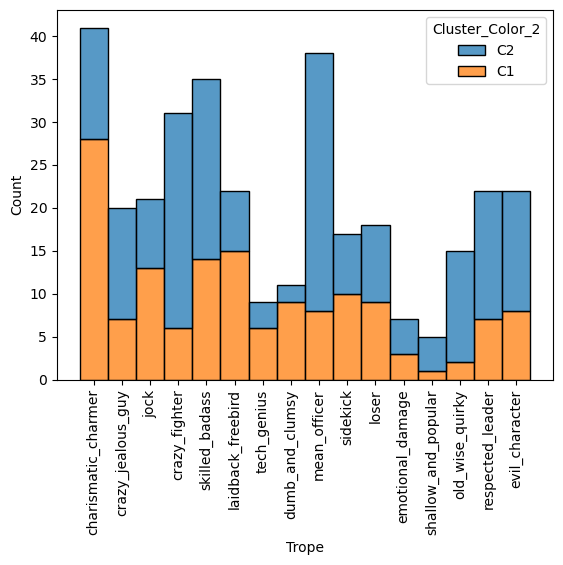

In [153]:
sns.histplot(data=subgroupC6, x='Trope', hue='Cluster_Color_2',multiple="stack")
plt.xticks(rotation=90)
plt.show()

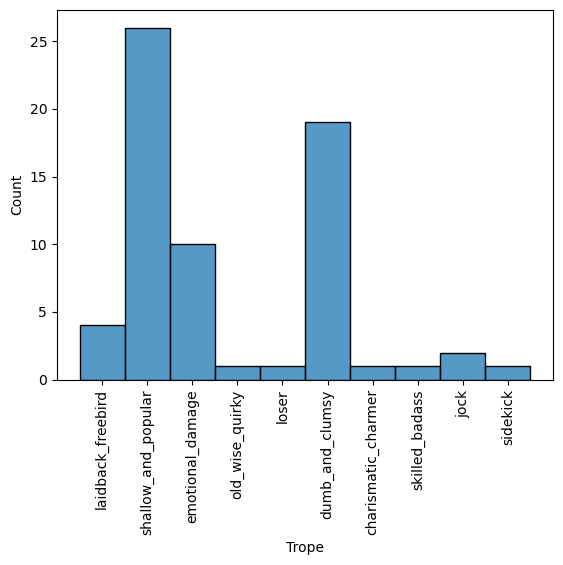

In [62]:
subgroup_orange=merge_features_filtered[merge_features_filtered['Cluster_Color']=='C1']
sns.histplot(subgroup_orange['Trope'])
plt.xticks(rotation=90)
plt.show()

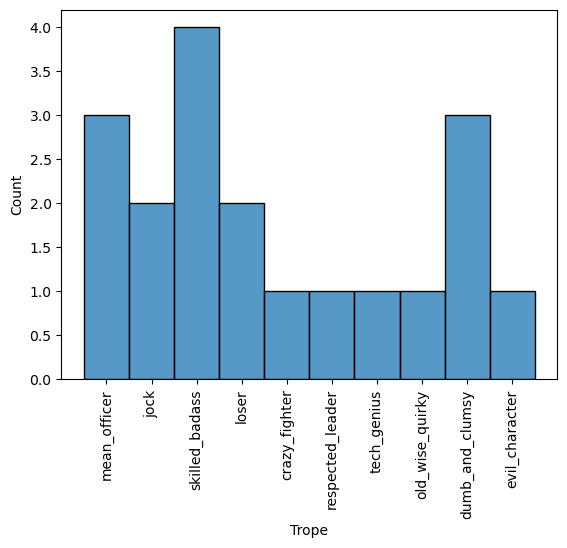

In [63]:
subgroup_vert=merge_features_filtered[merge_features_filtered['Cluster_Color']=='C2']
sns.histplot(subgroup_vert['Trope'])
plt.xticks(rotation=90)
plt.show()

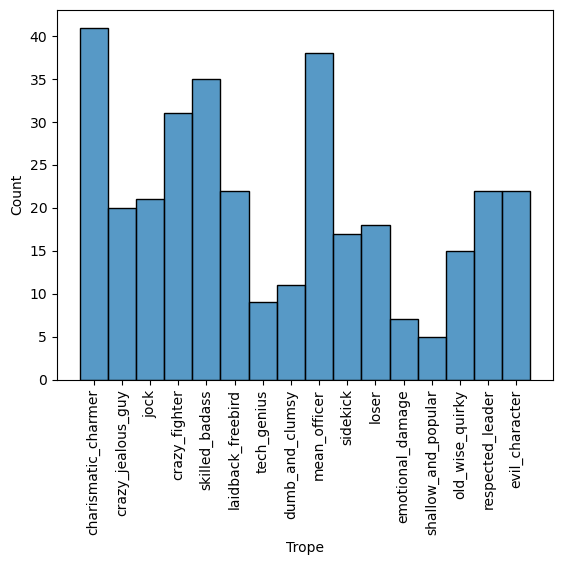

In [64]:
sns.histplot(subgroupC6['Trope'])
plt.xticks(rotation=90)
plt.show()

### PCA on characters

In [51]:
pca_columns= merge_features_filtered.loc[:,'encod_1':'encod_128']
num_components = 128 # Choose the number of components for 2D visualization
pca_principal = PCA(n_components=num_components)
pca_result = pca_principal.fit_transform(pca_columns)

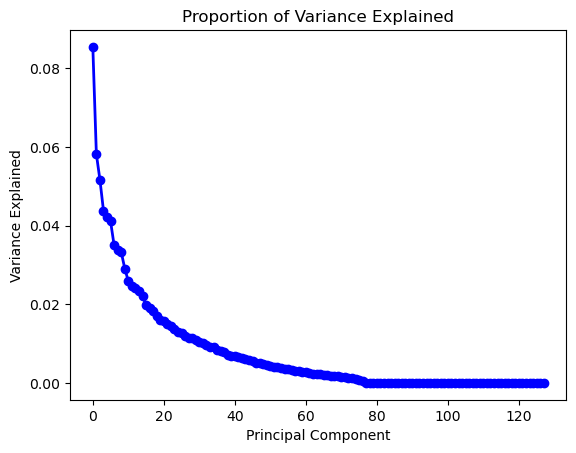

In [52]:
plt.plot(range(0,128), pca_principal.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

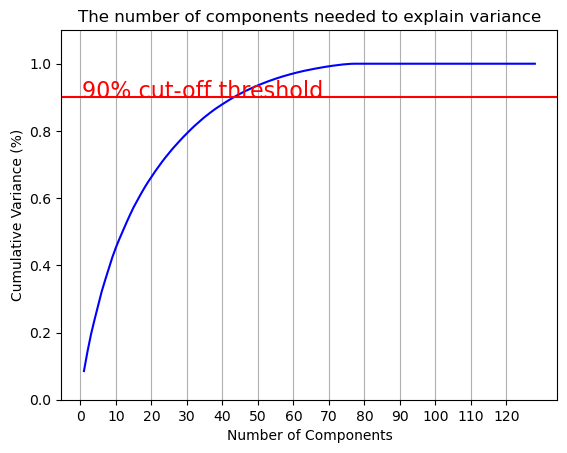

In [53]:
ig, ax = plt.subplots()
xi = np.arange(1, len(pca_principal.explained_variance_ratio_) + 1, step=1)
y = np.cumsum(pca_principal.explained_variance_ratio_)

plt.ylim(0.0, 1.1)
plt.plot(xi, y, linestyle='-', color='b') #, marker='.')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, len(pca_principal.explained_variance_ratio_) + 1, step=10))
plt.ylabel('Cumulative Variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.9, color='r', linestyle='-')
plt.text(0.5, 0.9, '90% cut-off threshold', color='red', fontsize=16)

ax.grid(axis='x')

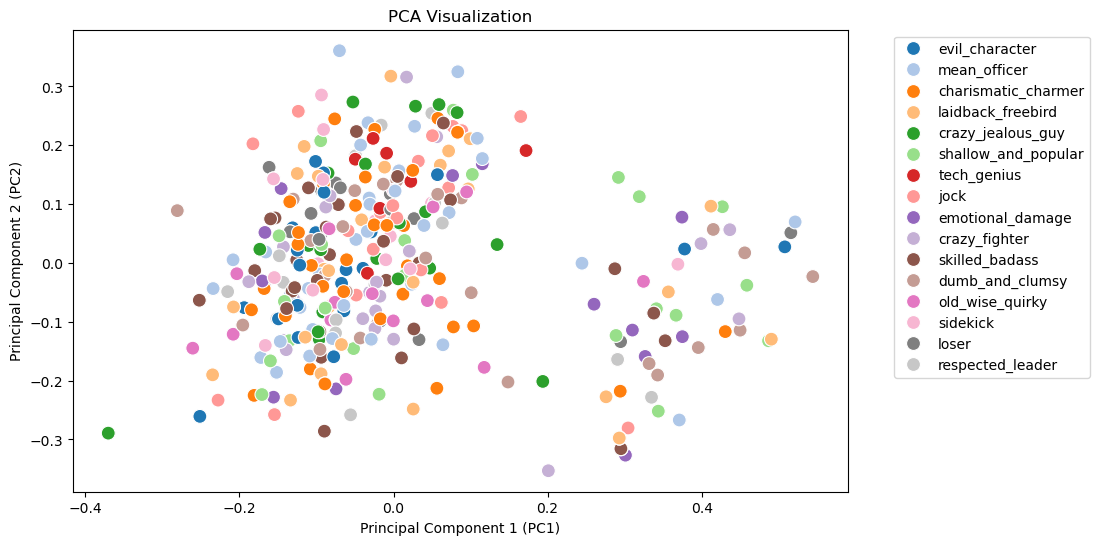

In [54]:
numeric_columns_4= merge_features_filtered.loc[:,'encod_1':'encod_128']
# Perform PCA
num_components = 6 # Choose the number of components for 2D visualization
pca4 = PCA(n_components=num_components)
pca_result4 = pca4.fit_transform(numeric_columns_4)

# Create a DataFrame with PCA results
df_pca4 = pd.DataFrame(data=pca_result4, columns=[f'PC{i+1}' for i in range(num_components)])

# Concatenate the principal components DataFrame with the original DataFrame
df_result4 = pd.concat([merge_features[['Trope','CharacterName','ActorName','MovieName','Genres','StrActorEthnicity','ActorGender','BoxOffice','ActorAge','ActorHeight']], df_pca4], axis=1)

# Visualize the PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca4.columns[0], y=df_pca4.columns[1], data=df_result4, hue='Trope', palette='tab20', s=100)
plt.title('PCA Visualization')
plt.xlabel(f'Principal Component 1 ({df_pca4.columns[0]})')
plt.ylabel(f'Principal Component 2 ({df_pca4.columns[1]})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

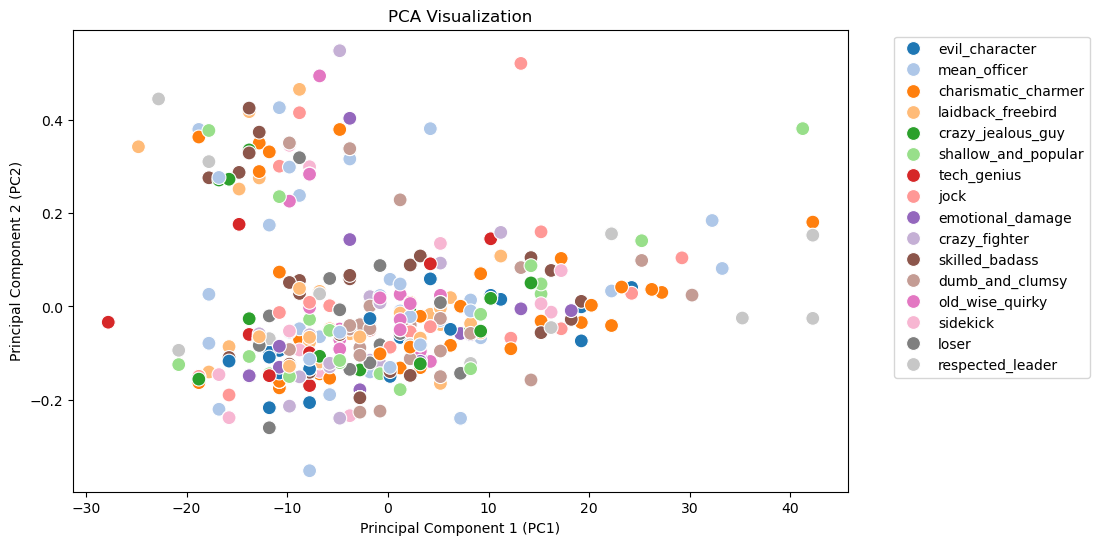

In [55]:
numeric_columns_4= merge_features_filtered_height.loc[:,'encod_1':'encod_128']
numeric_columns_4= pd.concat([merge_features_filtered_height['ActorHeight'], merge_features_filtered_height['ActorAge'],numeric_columns_4],axis=1)
# Perform PCA
num_components = 6 # Choose the number of components for 2D visualization
pca4 = PCA(n_components=num_components)
pca_result4 = pca4.fit_transform(numeric_columns_4)

# Create a DataFrame with PCA results
df_pca4 = pd.DataFrame(data=pca_result4, columns=[f'PC{i+1}' for i in range(num_components)])

# Concatenate the principal components DataFrame with the original DataFrame
df_result4 = pd.concat([merge_features[['Trope','CharacterName','ActorName','MovieName','Genres','StrActorEthnicity','ActorGender','BoxOffice','ActorAge','ActorHeight']], df_pca4], axis=1)

# Visualize the PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca4.columns[0], y=df_pca4.columns[1], data=df_result4, hue='Trope', palette='tab20', s=100)
plt.title('PCA Visualization')
plt.xlabel(f'Principal Component 1 ({df_pca4.columns[0]})')
plt.ylabel(f'Principal Component 2 ({df_pca4.columns[1]})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()